In [1]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

In [3]:
tagged_pitch_types = all_pitches['TaggedPitchType'].unique()

auto_pitch_types = all_pitches['AutoPitchType'].unique()

In [4]:
off_speed = all_pitches[all_pitches['TaggedPitchType'].isin(['ChangeUp','Splitter'])]

In [5]:
off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_19684\3639497680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)


In [6]:
os_preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','PlateLocHeight','PlateLocSide','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [7]:
off_speed_X = off_speed[os_preds]
off_speed_y = off_speed['whiff']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(off_speed_X, off_speed_y, test_size=.33)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.14%


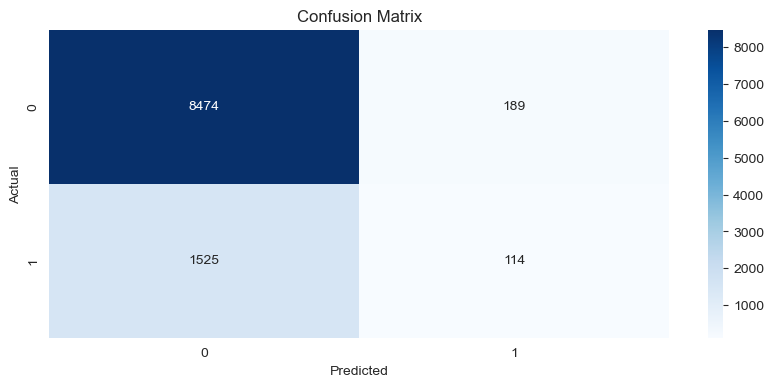

In [10]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
all_preds = model.predict_proba(off_speed_X)[:,1]
mean_pred = np.mean(all_preds)

print(mean_pred)

sample = off_speed_X.sample(n=10)

sample_preds = model.predict_proba(sample)[:,1]

stuff = sample_preds/mean_pred

print(stuff*100)

0.1518913
[356.69348    73.762085   21.121288  130.92816   119.51968    30.811314
 199.08481   398.07593     6.0342884  71.43755  ]


In [14]:
# Get unique values
unique_values = off_speed['Pitcher'].unique()

# Create a dictionary to store subsets
subsets = {value: off_speed[off_speed['Pitcher'] == value] for value in unique_values}

In [19]:
j_a = subsets['Graves, Griffin']
j_a['TaggedPitchType'].unique()

array(['ChangeUp'], dtype=object)

In [20]:
c_allsup = subsets['Graves, Griffin']
c_allsup_X = c_allsup[os_preds]

whiff_preds = model.predict_proba(c_allsup_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Chase Allsup off-speed stuff+:{np.mean(stuff*100)}")

Chase Allsup off-speed stuff+:90.9284896850586


In [14]:
b_schorr = subsets['Schorr, Ben']
b_schorr_X = b_schorr[os_preds]

whiff_preds = model.predict_proba(b_schorr_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Ben Schorr off-speed stuff+:{np.mean(stuff*100)}")

Ben Schorr off-speed stuff+:71.49032592773438
